# EDA Contribution — Keith (2026-01-23)


This notebook performs an exploratory analysis of the Mercedes-Benz test bench dataset to assess data structure, feasibility for regression modeling, and key risks relevant to downstream modeling and deployment.

The focus is descriptive and diagnostic rather than predictive.
No models are trained in this notebook.

## Data Loading

In [16]:
import sys
import os

# If imports fail, run once, then restart kernel
# !{sys.executable} -m pip install -U pandas seaborn matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Project import (repo installed via `pip install -e .`)
from src.data_loader import load_and_clean_data

# Path to data directory (notebooks/contrib → repo root → data)
data_path = "../../data"

try:
    X, y, X_test = load_and_clean_data(data_path)
    print("✅ SUCCESS: Data Loaded Successfully!")
    print(f"   - Training Cars: {X.shape[0]}")
    print(f"   - Features: {X.shape[1]}")
except Exception as e:
    print(f"❌ Error: {e}")
    print(f"Current Working Directory: {os.getcwd()}")

Loading data from ../../data...
⚠️  Dropped 12 constant columns.
✅ SUCCESS: Data Loaded Successfully!
   - Training Cars: 4209
   - Features: 364


In [10]:
# If imports fail, run this once, then restart kernel.
import sys
!{sys.executable} -m pip install -U pandas seaborn matplotlib

## dataset shape + feature type

In [17]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

obj_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

print("Categorical cols:", len(obj_cols))
print("Numeric / binary cols:", len(num_cols))

X shape: (4209, 364)
y shape: (4209,)
X_test shape: (4209, 364)
Categorical cols: 8
Numeric / binary cols: 356


/var/folders/zn/b0bgzvj50txcvq90qk08mvjm0000gn/T/ipykernel_86284/1220567680.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = X.select_dtypes(include="object").columns


## Target distribution cell

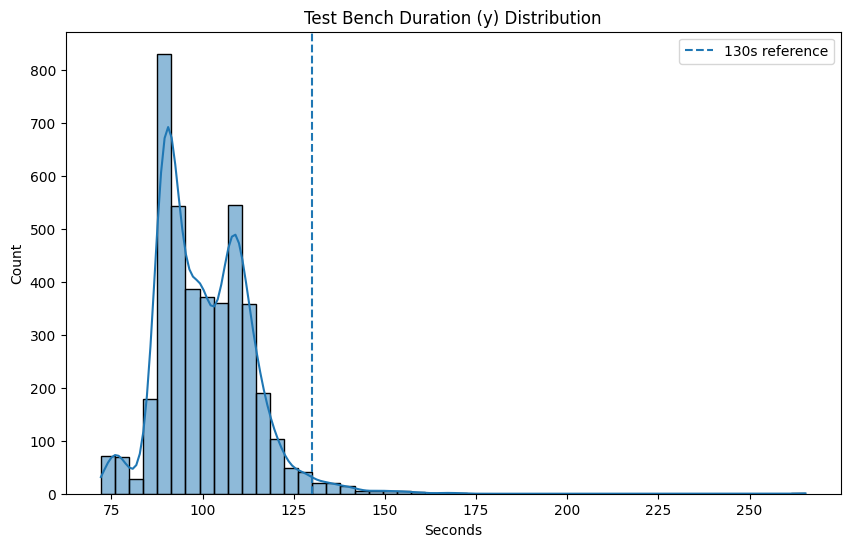

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64
Skew (approx): 1.206525852242492
Max: 265.32


In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=50, kde=True)
plt.title("Test Bench Duration (y) Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.axvline(130, linestyle="--", label="130s reference")
plt.legend()
plt.show()

print(y.describe())
print("Skew (approx):", y.skew())
print("Max:", y.max())

Observations:
- The target distribution is right-skewed.
- Extreme values are treated as real operational cases and are retained.

## Long-tail focus

In [19]:
p90, p95, p99 = y.quantile([0.90, 0.95, 0.99])
print(f"p90: {p90:.2f}s, p95: {p95:.2f}s, p99: {p99:.2f}s")
print("Share >130s:", (y > 130).mean())
print("Share >200s:", (y > 200).mean())

p90: 115.25s, p95: 120.81s, p99: 137.43s
Share >130s: 0.01924447612259444
Share >200s: 0.00023758612497030174


The long tail is small in frequency but operationally expensive, motivating
tail-sensitive metrics (e.g. RMSE) and error analysis beyond averages.

## Basic leakage / repetition check

In [20]:
dup_feat_rows = X.duplicated().sum()
print("Duplicate feature rows in X:", dup_feat_rows)

Duplicate feature rows in X: 298


- Data loaded: 4,209 rows with high-dimensional, sparse features after removing constants.
- Target `y` is continuous, positive, and right-skewed; extreme values are retained as real operational cases.
- A long tail exists (quantiles and threshold shares), so tail-sensitive evaluation is important.
- Feature space sparsity implies rare configuration combinations and generalization risk.
- Governance note: avoid validation leakage via repeated configurations; use group-aware splitting downstream.

## EDA Summary

This exploratory analysis confirms that the dataset is suitable for predicting test bench duration while highlighting key operational risks relevant to efficiency and sustainability targets. Test duration is a continuous, right-skewed variable, with a small number of long-running cases that occur infrequently but have disproportionate impact on production planning, capacity utilization, and test bench idle time. 

These cases are treated as valid operational scenarios and are retained in the dataset. The vehicle configuration feature space is high-dimensional and sparse, reflecting the inherent variability of production configurations and implying that rare combinations cannot be avoided. As a result, model evaluation must account for behavior in these low-frequency, high-impact cases rather than relying solely on average performance. 

In combination with the team’s configuration-level analysis, this EDA supports a modeling and validation approach that prioritizes robustness and predictable behavior, helping reduce inefficient sequencing, avoid unnecessary rework, and contribute to lower energy usage and CO₂ emissions at the test bench level.